In [11]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import random
import pandas
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats 
import sklearn
from sklearn.manifold import TSNE
from dataclasses import dataclass

from sklearn.decomposition import PCA, FastICA
from google.colab import files
from skimage.util.shape import view_as_windows
import seaborn as sns
#sns.set_style('darkgrid')
#sns.set_palette('muted')
#sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 1.25})

from google.colab import drive
drive.mount('/content/drive/')
#import windowing as wl
#import Experiment_toolkit as extk
#import DataAugmentation as DA
from scipy.interpolate import CubicSpline      # for warping
!pip install transforms3d
from transforms3d.axangles import axangle2mat  # for rotation


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [12]:
#ONLY ON 3 dimensional SENSOR DATA DO NOT PASS IN TIME

def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

def DA_TimeWarp(X, sigma):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,0], X[:,1]) #changed from tt_new[:,1], X[:,1]
    X_new[:,2] = np.interp(x_range, tt_new[:,0], X[:,2])#changed from tt_new[:,2], X[:,2]
    return X_new

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

def DA_Rotation_specific(X, angle_low, angle_high, axis):
    axis = np.array(axis)
    angle = np.random.uniform(low=angle_low, high=angle_high)
    return np.matmul(X, axangle2mat(axis, angle))

In [56]:

def create_train_test_validation(positives, negatives, percent_train, percent_test, percent_validation):
    """
        Description: creates a training, testing, and validation dictionary for binary data

        Args:
            positives -- np_array (List of positive samples as numpy arrays)
            negatives -- np_array (List of negative samples as numpy arrays)
            percent_train -- double ([0-1] Fraction of data to go to training set)
            percent_test -- double (0-1] Fraction of data to go to testing set)
            percent_validation -- double ([0-1] Fraction of data to go to validation set)

        Return:
            train -- dict (Dictionary with percent_train of original dictionary)
            test -- dict (Dictionary with percent_test of original dictionary)
            validation -- dict (Dictionary with percent_validation of original dictionary)
        """
    train = {"positives": [], "negatives": []}
    test = {"positives": [], "negatives": []}
    validation = {"positives": [], "negatives": []}

    if (percent_train + percent_test + percent_validation != 1):
        print("ERROR: percentages don't add to 1")

    train, test, validation = splitting_up_data(
        positives, "positives", train, percent_train, test, percent_test, validation, percent_validation)
    train, test, validation = splitting_up_data(
        negatives, "negatives", train, percent_train, test, percent_test, validation, percent_validation)

    return train, test, validation


def splitting_up_data(data, key, train, percent_train, test, percent_test, validation, percent_validation):
    """
        Description: Splits up data from dictionary using the given percentages to make a train, test, and validation set

        Args:
            data -- np array (Array of samples as numpy arrays)
            key -- String (Key for the in dictionary from which we will split up the data from)
            train -- dict (Training dictionary )
            percent_train -- double ([0-1] Percentage of data to go to training set)
            test -- dict (Testing dictionary )
            percent_test -- double (0-1] Percentage of data to go to testing set)
            validation -- dict (Validation dictionary )
            percent_validation -- double ([0-1] Percentage of data to go to validation set)

        Return:
            train -- dict (Dictionary with percent_train of list)
            test -- dict (Dictionary with percent_test of list)
            validation -- dict (Dictionary with percent_validation of list)
        """
    length = len(data)
    train_index = int(length * percent_train)
    test_index = int(length * percent_test)
    train[key] = data[0:train_index]
    test[key] = data[train_index:train_index + test_index]
    validation[key] = data[train_index + test_index:]
    return train, test, validation


def preprocess_data(data, rows, filtering_params, window_function, window_size, offset):
    """
       Description: Process the samples stored in data by windowing the traces and saving
                                these windows (numpy arrays) into a dictionary.

       Args:
            data -- list (List of numpy arrays where the last row is time steps, 
            			  [(sensor_dims + 1), num_samples])
            rows -- int (Number of rows in the data)
            filtering_params -- All_Filtering_Params (Dataclass found in windowing.py that 
                                stores important parameters for the 2 steps involved with 
                                finding the precise start and end time of a activity in the data)
            window_size -- int (Window size of the trace to be saved into the
            				    numpy array windows that will be returned)
            offset -- int (Number to add to the predicted start time of the 
            			   activity from where the window will start at)

       Return:
           windows-- int[] (Array of the windows cropped by the window_function)
           """
    windows = []
    for sample in data:
        activity_windows = initial_find_activity(
            sample, rows, filtering_params.initial_filtering.window_size,
            filtering_params.initial_filtering.stride,
            filtering_params.initial_filtering.divisor)
        if len(activity_windows) > 0:
            start_time, end_time = get_start_time(
                activity_windows, rows, filtering_params.precise_filtering.window_size,
                filtering_params.precise_filtering.stride,
                filtering_params.precise_filtering.threshold)
            windowed_trace = window_function(
                sample, start_time + offset, window_size)
            if len(windowed_trace[0][0]) != window_size:
                continue
            windows.extend(windowed_trace)
    np_windows = np.array(windows)
    return np_windows


def get_np_X_Y(x, y, length):
    """
       Description: Create X and Y numpy arrays desired length of random 
       				samples (without replacement) from lists of windowed data, x and y

       Args:
           x -- np_array (Numpy array of one category numpy arrays with the same shape)
           y -- np_array (Numpy array of another category numpy arrays with 
           				  the same shape as x numpy arrays)
           length -- int Number of samples in the numpy array to be returned 

       Return:
            X -- np array (Numpy array where the first half of the data points
            			  come from x and second half comes from y)
            y -- np array (Numpy array with length = length with binary labels 
            			   (1, 0) for the differetn x, y data points)
           """
    len1 = len(x)
    len2 = len(y)
    limit = min(len1, len2, length)
    idx = np.random.randint(len1, size=limit)
    idx2 = np.random.randint(len2, size=limit)
    rnd_x = x[idx]
    rnd_y = y[idx2]
    X = np.concatenate((rnd_x, rnd_y))
    pos = np.ones(limit)
    neg = np.zeros(limit)
    y = np.concatenate((pos, neg))
    return X, y


def create_dataset(pos, neg, max_samples):
    """
       Description: Create a tf.data.Dataset composed of samples from the pos and neg list 

       Args:
           pos -- np array (Numpy arrays of positive windows, [(sensor_dims), num_samples])
           neg -- np arrya (Numpy arrays of negative windows, [(sensor_dims), num_samples])
           max_size -- int (number of samples to be taken from pos and neg to
                                                be used in the dataset. If max_size < 0, then all 
                                                samples from both pos and neg will be used) 

       Return:
           dataset -- tf.data.Dataset (TensorFlow dataset composed of the 
                                  positive and negative lists of data passed into the 
                                  function with the corresponding labels)
     """
    np.random.shuffle(pos)
    np.random.shuffle(neg)
    if (max_samples > 0):
        pos = pos[:max_samples]
        neg = neg[:max_samples]
    examples = np.concatenate((pos, neg))
    pos_label = np.ones(len(pos))
    neg_label = np.zeros(len(neg))
    labels = np.concatenate((pos_label, neg_label))
    dataset = tf.data.Dataset.from_tensor_slices((examples, labels))
    return dataset


def preprocess_add_augmentation(data, augmentation_function, sigma):
    """
       Description: Iterate over DATA and proprocess the traces by adding an augmentation function
                                to the data.

       Args:
           data -- list (List of numpy array where the last row is time steps, [(sensor_dims + 1), num_samples])
           dictionary -- dict (Dictionary to store augmented traces)
           pos_key -- string (Key in dictionary to store augmented windows) 
           augmentation_function -- function (Desired augmentation function of the form:
                                              augment(np_array data, int sigma))
           sigma -- double (Level of augmentation to be passed to the augmentation function )
           size -- int (Window size of traces to be stored in dictionary)

       Return:
           dictionary -- dict (Dictionary with augmented windows of size = size in key pos_key)
     """
    augmented = []
    for sample in data:
        sample_no_timeseries = sample[:-1]
        transposed = sample_no_timeseries.transpose()
        augmented_trace = augmentation_function(transposed, sigma)
        augmented_trace = augmented_trace.transpose()
        augmented.extend([augmented_trace])
    return augmented



def scatter_PCA(X, Y, components, alpha):
    pca = PCA(n_components=components)
    pca_result = pca.fit_transform(X)
    scatter_plot(pca_result, Y, alpha)


def scatter_ICA(X, Y, components,alpha):
    ica = FastICA(n_components=components)
    ica_result = ica.fit_transform(X)
    scatter_plot(ica_result, Y, alpha)


def scatter_TSNE(X, Y, components, alpha):
    RS = 20150101
    TSNE_proj = TSNE(random_state=RS, n_components=components).fit_transform(X)
    scatter_plot(TSNE_proj, Y, alpha)


def scatter_plot(result, Y, alpha):
    df_subset = {"negative": [], "positive": []}
    df_subset['positive'] = result[:, 0]
    df_subset['negative'] = result[:, 1]
    df_subset['y'] = Y
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x="negative", y="positive",
        hue="y",
        palette=sns.color_palette("hls", 2),
        data=df_subset,
        legend="full",
        alpha=alpha
    )



In [32]:
@dataclass
class Initial_Filtering_Params:
    window_size: int
    stride: int
    divisor: int
    rows: int 

@dataclass
class Precise_Filtering_Params:
    window_size: int
    stride: int
    threshold: int
    rows: int

@dataclass
class All_Filtering_Params:
    initial_filtering: Initial_Filtering_Params
    precise_filtering: Precise_Filtering_Params


def dict_to_numpy_array(dictionary):
    """
    Description: converts dictionary of raw data to and Numpy array. 

    Args:
        dictionary -- Dictionary of data to be converted to Numpy array. All the entries
                      within the keys must be the same length for the Numpy.append function
                      to work.

    Return:
        np_array -- np array (Np array the data in dictionary)
    """
    np_array = np.array([[]])
    i = 0
    for key in dictionary:
        if (i == 0):
            np_array = np.array([dictionary[key]])
        else:
            np_array = np.append(np_array, [dictionary[key]], axis=0)
        i += 1
    return np_array


def create_windows_from_dictmatrix(dict_matrix, rows, window_size, stride):
    """
    Description: Takes dictionary that contains x, y, z, nanos keys and transforms
                 this into an np array. Then creates windows from this matrix and returns
                 the windows

    Args:
        dict_matrix -- Dictionary to create windows from
        rows -- int (Number of rows in a trace)
        window_size -- int (# of samples within one window when creating the windows)
        stride -- int (# of samples between the start of each window)

    Return:
        windowed_data -- np array (Np array of the windowed data)
    """

    np_data = dict_to_numpy_array(dict_matrix)
    windowed_data = view_as_windows(np_data, (rows, window_size), step=stride)
    return windowed_data


def find_initial_activity_times(activity_windows, rows): 
    """ 
    Description: Returns the start and end times from activity_windows np array

    Args:
        activity_windows -- np array
        rows -- int (Number of rows in a trace)

    Return:
        start -- int (Start time in nanos)
        end -- int (End time in nanos)
    """
    start = activity_windows[0][rows-1][0]
    end = activity_windows[-1][-1][-1]
    return start, end


def find_activity_windows(windowed_data, divisor, threshold, return_activity_windows):
    """
    Description: Takes the windowed data and calculates variance for each window.
                 Then calculates variance threshold and returns an np array of
                 the windows that meet the variance threshold.
    Args:
        windowed_data -- np array [[[[x1],[y1],[z1],[nanos1]], [[x2], [y2],
                                         [z2], [nanos2]]...]
        divisor -- int (Will use divisor to calculate variance threshold so
                   that the threshold is a function of the max variance. If using
                   a set threshold, make divisor = 0.
                   Threshold = (max variance)/divisor)
        threshold -- int (Used as the variance threshold. If using a divisor to
                          find the variance threshold, leave threshold = 0)
        return_activity_windows -- boolean: (True:  will return a list of
                                         activity_windows that meet the variance threshold)
                                        (False: will return just the start time of the activity_windows)

    Return:
        activity_windows -- np array (A np_array of windows that meet the desired
                                  threshold)
        -- or --
        start_time -- int (Start time in nanos of the activity_windows)

     """
    if (threshold != 0 and divisor != 0):
        print("ERROR: Either divisor or threshold need equal to 0 to specify which to use.")
        return -1
    if (threshold != 0):
        divisor = 0
    indices = find_indices_that_meet_threshold(
        windowed_data, threshold, divisor)

    windows = windowed_data[0]
    if (return_activity_windows):
        return get_activity_windows_from_indices(indices, windowed_data)
    else:
        if (indices.size == 0):
            return None
        index_of_start = indices[0]
        start_time = windows[index_of_start][0][-1][0]
        return start_time


def get_activity_windows_from_indices(indices, windowed_data):
    """
        Description: Finds the largest set of continuous windows from the indices
                     array

        Args:
            windowed_data -- np array (Windowed data numpy array)
            indices -- np array (Numpy array of indices of the windowed data that meet the variance threshold)

        Return:
            activity_windows -- np_array (Cropped activity window)
        """
    windows = windowed_data[0]
    if (indices.size <= 1):
        indices = indices[0]
    else:
        indices = np.squeeze(indices)
        indices_diff = np.diff(indices)
        end_time = np.argwhere(indices_diff != 1)
        end_time = np.insert(end_time, 0, 0 )
        end_time = np.insert(end_time, len(end_time), len(indices)-1)
        end_time_diff = np.diff(end_time)
        max_index = np.argmax(end_time_diff)
        end_time = end_time[max_index :]
        if (end_time.size != 0):
            indices = indices[end_time[0] + 1 :end_time[1]+1]
    activity_windows = np.take(windows, indices, axis=0)
    return activity_windows


def find_indices_that_meet_threshold(windowed_data, threshold, divisor):
    """
    Description: Finds indices that meet the desired threshold level

    Args:
        windowed_data -- np array
        threshold -- int (Threshold for variance, if using a divisor set to 0 instead)
        divisor -- int (Divisor to set threshold, if using threshold set to 0 instead)


    Return:
        indices -- np_array (Array of indices that correspond to windows in
                   windowed_data that meet the variance threshold level)
    """
    windows = windowed_data[0]
    windows_no_time = windows[:, :-1]
    variances = np.var(windows_no_time, axis=2, ddof=1)
    var_sum = np.sum(variances, axis=1)
    if divisor == 0:
        variance_threshold = threshold
    else:
        variance_threshold = max(var_sum)/divisor
    indices = np.argwhere(var_sum > variance_threshold)
    return indices


def find_precise_start_time(activity_windows, rows,
                            window_size, stride, variance_threshold):
    """
    Description: Finds a more precise start time by creating much smaller windows
                 within the first window found to contain part of the activity ouputted
                 from initial_find_activity.
    Args:
        activity_windows -- np array
        rows -- int (# of rows within a trace (ex: x, y, z, nanos => 4 rows))
        window_size -- int (# of samples within one window when creating the windows)
        stride -- int (# of smaples in between the start of each window)
        variane_threshold -- int (Variance threshold that determines
                             wether the current window is part of the activity)

    Return:
        start_time = int (more precise start time of the activity in nanoseconds)
    """
    front = activity_windows[0]
    divisor = 0
    return_activity_windows = False
    windowed_data = view_as_windows(front, (rows, window_size), stride)
    start_time = find_activity_windows(
        windowed_data, divisor, variance_threshold, return_activity_windows)
    return start_time


def initial_find_activity(sample, rows, window_size, stride, divisor):
    """
    Description: Finds set of windows whose variance meets a
                         threshold indicating it contains part of the 'activity'

    Args:
        sample -- np array (Numpy array where the last row is time steps)
        rows -- int (# of rows within a trace (ex: x, y, z, nanos => 4 rows))
        window_size -- int (# of samples within one window when creating the windows)
        stride -- int (# of smaples in between the start of each window)
        divisor -- int (Will be used to find variacne threshold : threshold = (max variance)/divisor)

    Return:
        activity_windows -- np array (an array of windows that meet the variance threshold)
    """
    windowed_data = view_as_windows(sample, (rows, window_size), stride)
    return_activity_windows = True
    threshold = 0
    activity_windows = find_activity_windows(
        windowed_data, divisor, threshold, return_activity_windows)
    return activity_windows


def cropped_np(np_sample, start, end):
    """
        Description: Returns the cropped sample from the start and end time in nanos

        Args:
            np_sample -- np array (Np array to be cropped)
            start -- int (Start time in nanos to begin crop)
            end -- int (End time in nanos the end crop)

        Return:
            cropped -- np array (a np array from start to end time in nanos)
        """
    time = np_sample[-1]
    start_index = np.where(time == start)
    end_index = np.where(time == end)
    cropped = [np_sample[:,  start_index[0][0]:end_index[0][0] + 1]]
    return cropped


def get_start_time(activity_windows, rows, window_size, stride, variance_threshold):
    """
        Description: Returns the precise start time

        Args:
            activity_windows -- np_array (Np array of the activity windows)
            rows -- int (# of rows within a trace (ex: x, y, z, nanos => 4 rows))
            window_size -- int (# of samples within one window when creating the windows)
            stride -- int (# of samples to jump before creating next window)
            variance_threshold -- int (Variance threshold that determines
                                  wether the current window is part of the activity)

        Return:
            start_time -- int (start time in nanos)
            end -- int (end time in nanos)
        """
    start, end = find_initial_activity_times(activity_windows, rows)
    precise_start = find_precise_start_time(
        activity_windows, rows, window_size, stride, variance_threshold)
    if (precise_start != None):
        start_time = precise_start
    else:
        start_time = start
    return start_time, end


def centered_window(np_sample, center_time, window_size):
    """
    Description: Creates a window centered around the center_time of the activity

    Args:
        np_sample -- np array (The full trace as an np array)
        center_time -- int (Time in nanoseconds that the window should be centered around)
        window_size -- int (Size of window)


    Return:
        window -- np_array (Window centered around the given time)
    """
    time = np_sample[-1]
    center_index = np.argwhere(time == center_time)[0][0]
    add_front = int(window_size/2)
    add_back = window_size - add_front
    back_index = center_index + add_back
    front_index = center_index - add_front
    last = len(np_sample[0])-1
    if (front_index < 0):
        add_back += abs(front_index)
        front_index = 0
        back_index = center_index + add_back
    if (back_index > last):
        add_front = abs(last - back_index) + add_front - 1
        back_index = last + 1
        front_index = center_index - add_front
        if (front_index < 0):
            front_index = 0
    window = [np_sample[:, front_index: back_index]]
    return window


def get_window_from_timestamp(np_sample, start_time, window_size):
    """
    Description: Creates a window that begins at start_time and has a length = window_size.
                 Additionally, if the start_time is negative or the window size means
                 that the window will go out of range of np_sample, this function will 
                 wrap around and create a window of the same size that is just bounded by
                 np_sample length

    Args:
        np_sample -- np array (The full trace as an np array)
        start_time -- int (Time in nanoseconds that the window should start at)
        window_size -- int (Size of window)


    Return:
        window -- np_array (Window centered around the given time)
    """
    time = np_sample[-1]
    start_index = np.argwhere(time == start_time)[0][0]
    add_back = window_size
    back_index = start_index + add_back
    front_index = start_index
    last = len(np_sample[0])-1
    if (front_index < 0):
        add_back += abs(front_index)
        front_index = 0
        back_index = stat_index + add_back
    if (back_index > last):
        add_front = abs(last - back_index) - 1
        back_index = last + 1
        front_index = start_index - add_front
        if (front_index < 0):
            front_index = 0
    window = [np_sample[:, front_index: back_index]]
    return window


def same_window_size(np_sample, start, window_size):
    rows = len(np_sample)
    windowed_data = view_as_windows(np_sample, (rows, window_size), 10)
    return windowed_data[0]

In [15]:
def plot(matrix):
  # matrix must be one sample:  4D with x, y, z, nanos (DATA[key][0])
  x = matrix['x']
  y = matrix['y']
  z = matrix['z']
  nanos = matrix['nanos'] 
  plt.plot(nanos, x,'r' ,nanos, y,'b', nanos, z,'palegreen')
  plt.show()

In [16]:
def graph_numpy(array):
  x = array[0]
  y = array[1]
  z = array[2]
  plt.plot(x,'r' , label = "x-axis")
  plt.plot(y,'b',label="y-axis")
  plt.plot(z,'palegreen', label = "z-axis")
  plt.legend(loc='best', prop={"size":10})
  plt.xlabel("Time", size= 18)
  plt.ylabel("Accleration", size= 18)
  plt.show()

#**Importing Data**#
Import the sensor data and configure each sample to a numpy array as seen below. The numpy array can have any number of features as long as the last row is for time. If there is no time data, the last row can simply hold the indices for the data. 

Numpy Array: ```[X, Y, Z, ... , time]```

In the example below, we use sensor data from [this study](https://archive.ics.uci.edu/ml/datasets/Dataset+for+ADL+Recognition+with+Wrist-worn+Accelerometer)  that includes 14 simple tasks that participants did with a wrist-worn accelerometer. In the set-up process, we transform the data into a numpy array and then store it in a dictionary with an appropriate action key.

In [17]:
STANDUP_CHAIR_PATH = '/content/drive/My Drive/Colab Notebooks/HMP_Dataset/Standup_chair/'
WALK_PATH = '/content/drive/My Drive/Colab Notebooks/HMP_Dataset/Walk/'
standup_chair = "STANDUP_CHAIR"
walk = "WALK"
DATA = {standup_chair : [], walk: []}

##**Set-Up:**##

The number of feautures should be constant throughout the data samples but the number of data points for each trace may vary

In [18]:

for file in os.listdir(STANDUP_CHAIR_PATH):
    if file.endswith(".txt"):
        df = pandas.read_table(STANDUP_CHAIR_PATH + file, delim_whitespace=True, names=['X', 'Y', 'Z'])
        df['X'] = df['X'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['Y'] = df['Y'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['Z'] = df['Z'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['id'] = df.index
        x = df.to_numpy().transpose()
        DATA[standup_chair].extend([x]) # SHAPE = (# of features, timesteps) 
x.shape

(4, 287)

In [19]:
for file in os.listdir(WALK_PATH):
    if file.endswith(".txt"):
        df = pandas.read_table(WALK_PATH + file, delim_whitespace=True, names=['X', 'Y', 'Z'])
        df['X'] = df['X'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['Y'] = df['Y'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['Z'] = df['Z'].map(lambda val: (val/63)*3*9.8 - (1.5 * 9.8) )
        df['id'] = df.index
        x = df.to_numpy().transpose()
        DATA[walk].extend([x]) # SHAPE = (# of features, timesteps) 
x.shape

(4, 1050)

##**Initialize Parameters**##
```
@dataclass
class Initial_Filtering_Params:
    window_size: int
    stride: int
    divisor: int
    rows: int 

@dataclass
class Precise_Filtering_Params:
    window_size: int
    stride: int
    threshold: int
    rows: int

@dataclass
class All_Filtering_Params:
    initial_filtering: Initial_Filtering_Params
    precise_filtering: Precise_Filtering_Params
```

To set parameters for the multi-resolution windowing algorithm, we instansiate dataclasses with the parameters we will need. I have chosen parameters that work with the dataset being used, but these will likely change based on the shape and size of the data it is being used on. Adjusting the parameters is more of an art than a science. These parameters will change how the start and end times are calcualted on the sensor data, so adjust them until. 



In [21]:
params1 = Initial_Filtering_Params(window_size = 25, stride = 5, divisor = 10, rows = 4)
params2 = Precise_Filtering_Params(window_size = 6, stride = 1, threshold = 1, rows = 4)
filtering_params = All_Filtering_Params(params1, params2)

Iterate over the numpy arrays in DATA["STANDUP_CHAIR"] and print out the accelerometer data with the calculated start and end times:

In [22]:
rows = 4

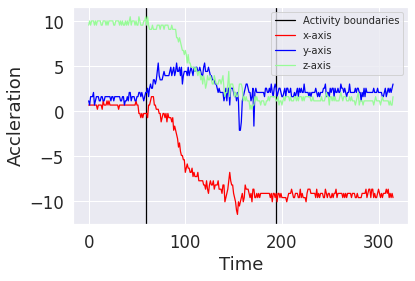

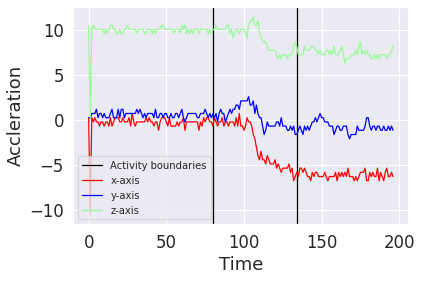

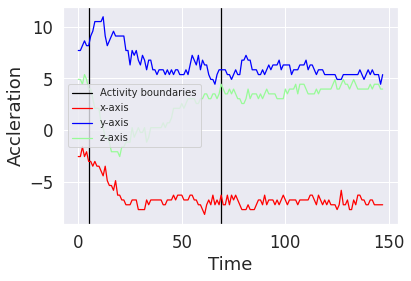

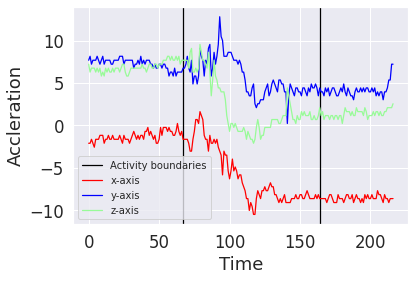

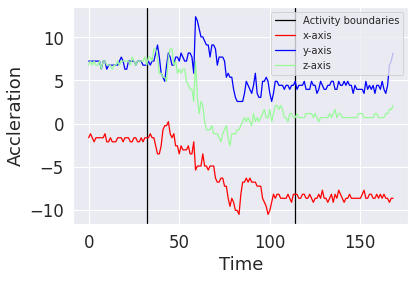

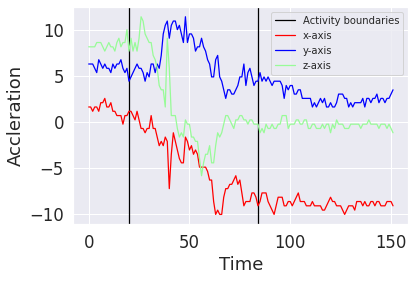

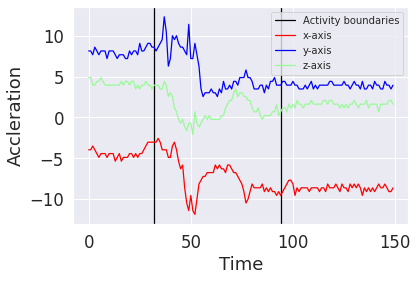

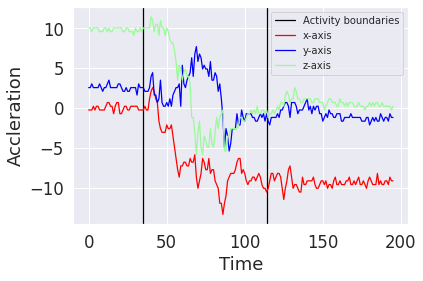

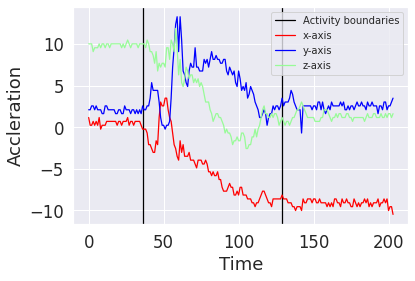

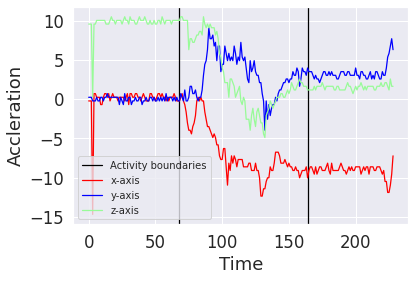

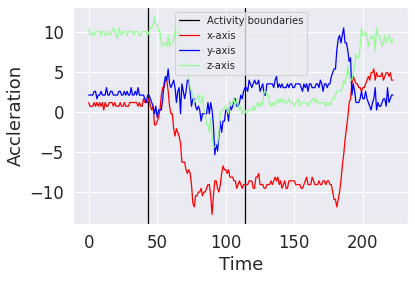

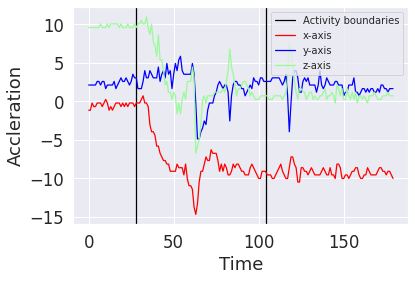

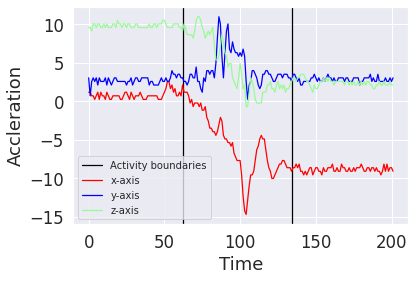

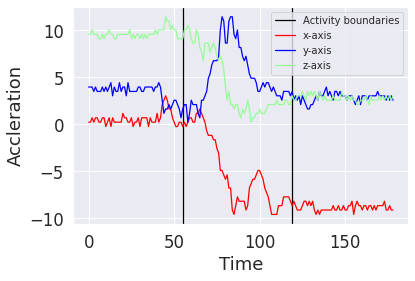

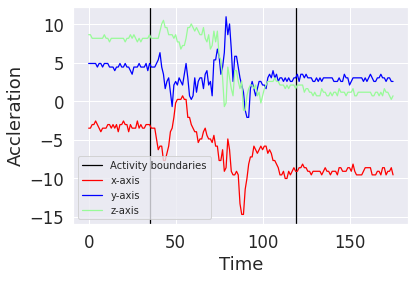

In [23]:
for j in range(15):
    sample = DATA[standup_chair][j]
    lift_windows = initial_find_lift(sample, filtering_params.initial_filtering.rows, filtering_params.initial_filtering.window_size, filtering_params.initial_filtering.stride, filtering_params.initial_filtering.divisor)
    if len(lift_windows) > 0:
        start_time, end_time = get_start_time(lift_windows, rows, filtering_params.precise_filtering.window_size, filtering_params.precise_filtering.stride, filtering_params.precise_filtering.threshold)

        plt.axvline(x=start_time, color = 'black')
        plt.axvline(x=end_time, color = 'black', label = "Activity boundaries")
        graph_numpy(sample)


###**Graph Walking Data**
* to take a look at the shape of the walking data we can graph a few of the traces

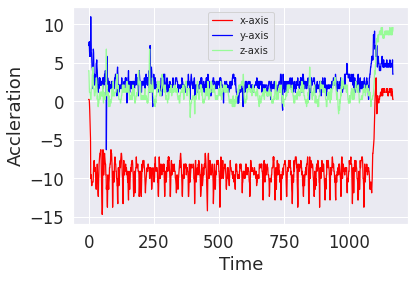

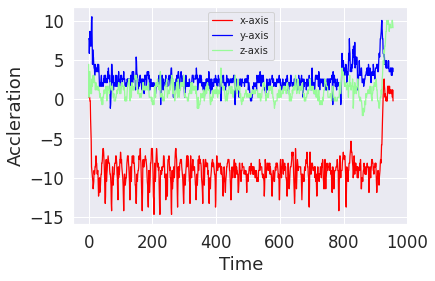

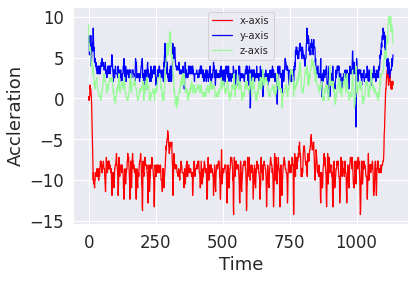

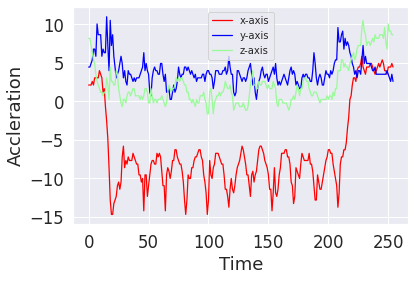

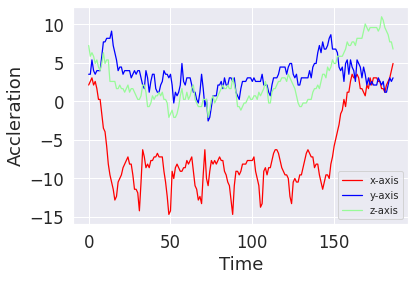

In [24]:
for j in range(5):
    sample = DATA[walk][j]
    graph_numpy(sample)

#**Histogram of Activity Length**#
To know how long the activity of standing up from a chair takes, we will create a histogram or the activity length to better understand the data. 

In [25]:
rows = 4
activity_length = []
for j in range(len(DATA[standup_chair])):
    sample = DATA[standup_chair][j]
    lift_windows = initial_find_lift(sample, filtering_params.initial_filtering.rows, filtering_params.initial_filtering.window_size, filtering_params.initial_filtering.stride, filtering_params.initial_filtering.divisor)
    if len(lift_windows) > 0:
        start_time, end_time = get_start_time(lift_windows, rows, filtering_params.precise_filtering.window_size, filtering_params.precise_filtering.stride, filtering_params.precise_filtering.threshold)
        activity_time = end_time - start_time
        activity_length.append(activity_time)

Number of sample:  102
DescribeResult(nobs=102, minmax=(32.0, 264.0), mean=91.15686274509804, variance=984.3315860997864, skewness=2.002397543387474, kurtosis=7.9013059295494035)


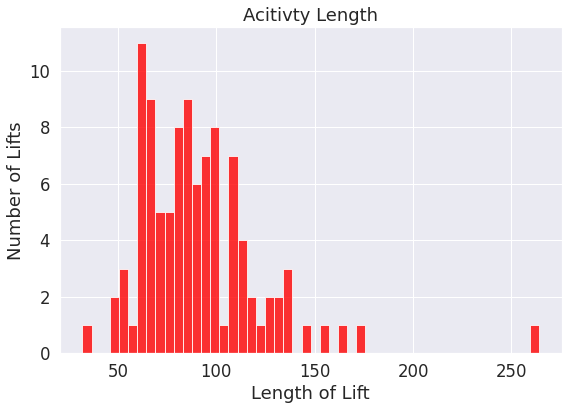

In [26]:
print("Number of sample: ", len(activity_length))
plt.figure(figsize=(9,6))
plt.hist(activity_length, 50, facecolor='red', alpha=0.8)
plt.title("Acitivty Length", size = 18)
plt.xlabel("Length of Lift", size= 18)
plt.ylabel("Number of Lifts", size = 18)
print(stats.describe(activity_length))

#**Different Windows**
After finding the start and end times of the activity, we may want to use this information to create windows of a set size that will be useful. In this library, there are 2 window creating functions:
* ```get_window_from_timestamp(np_sample, start_time, window_size)```
* ```centered_window(np_sample, center_time, window_size)```

These functions return return ``` int[] ``` with windows of all the same size, thus is very useful for preprocessing traces to be used in t-SNE, PCA, etc. calculations along with machine learning. Another thing to note is that these functions will wrap around and balance themselves within the trace so the size of the windows will = ```window_size``` 


**Use Case**
* experiments with the affect of different windows on model accuracy 
* show which parts of the data is most impactful when classifying different activities


###**Centered Window**
* the ```offset``` is added to the center point time of the window so that you can easily affect the sliding of the window along the trace
* the ```window_size``` refers to number of data points in one window

This function creates a window centered around a specific time and always gaurentees that the resulting window will have length = ```window_size``` unless ```window_size > length of the trace``` in which case the function returns the whole trace unaltered. Below, I have graphed a few windows to show how the function behaves on the traces. 

In [27]:
WINDOW_SIZE = 40
OFFSET = 0

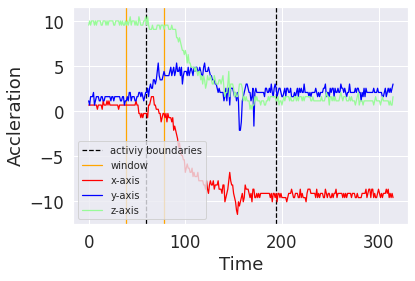

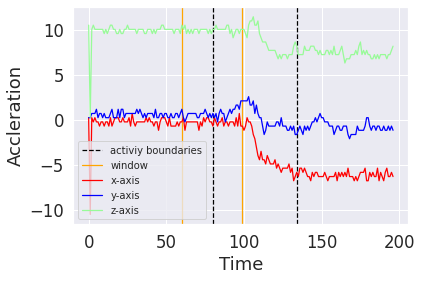

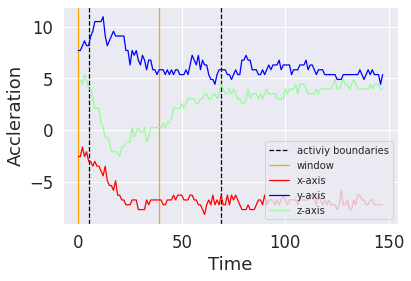

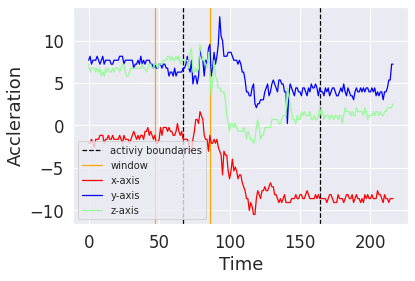

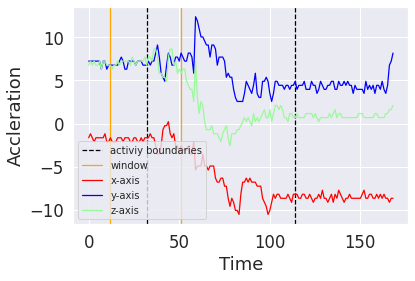

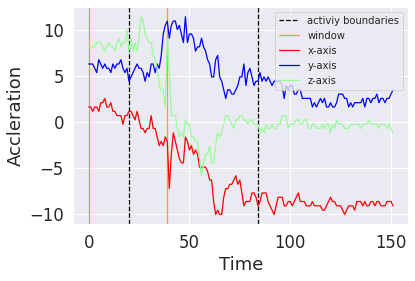

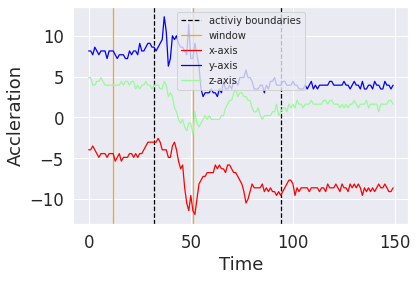

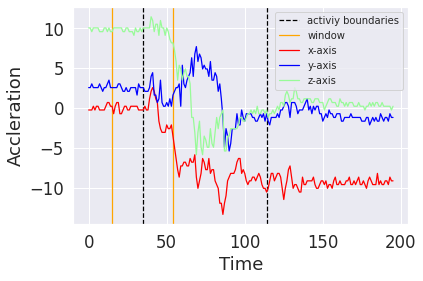

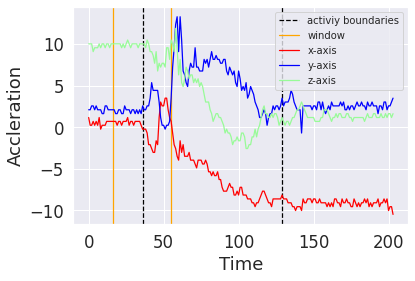

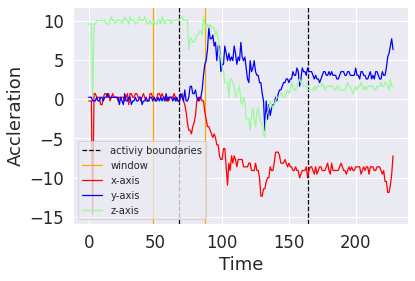

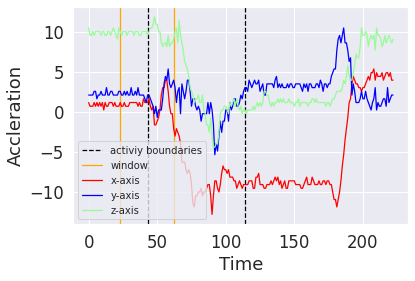

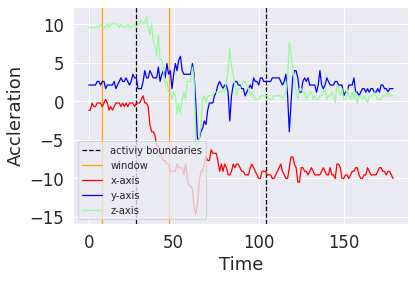

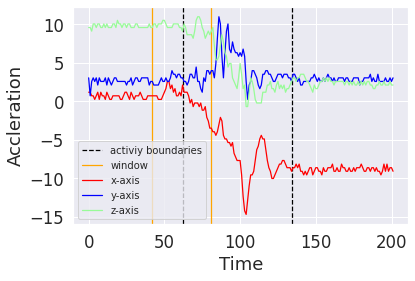

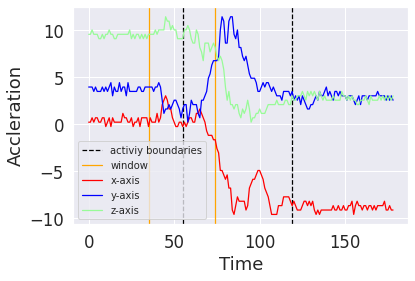

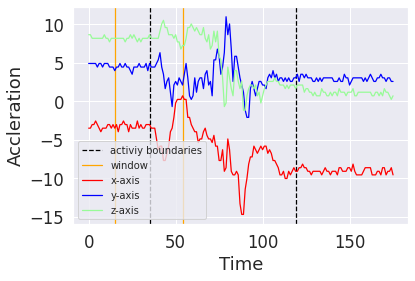

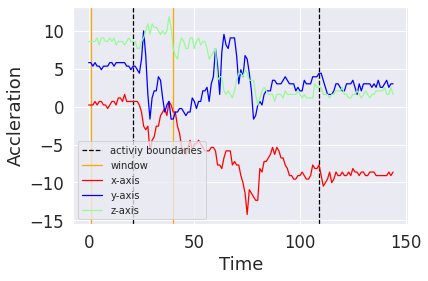

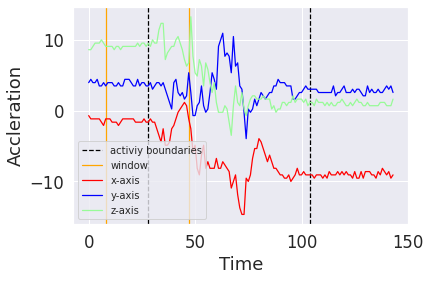

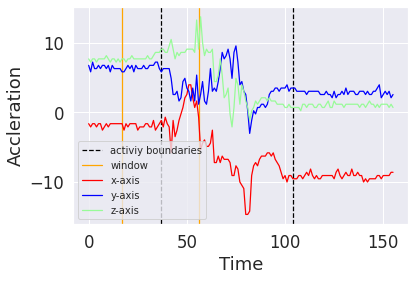

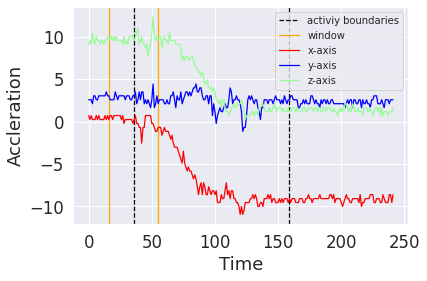

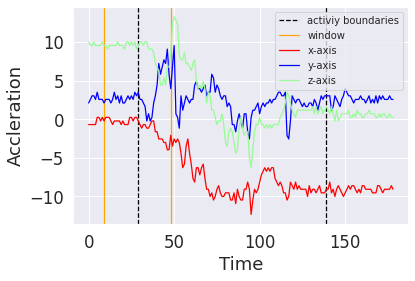

In [28]:
for j in range(20):
    sample = DATA[standup_chair][j]
    lift_windows = initial_find_lift(sample, filtering_params.initial_filtering.rows, filtering_params.initial_filtering.window_size, filtering_params.initial_filtering.stride, filtering_params.initial_filtering.divisor)
    if len(lift_windows) > 0:
        start_time, end_time = get_start_time(lift_windows, rows, filtering_params.precise_filtering.window_size, filtering_params.precise_filtering.stride, filtering_params.precise_filtering.threshold)
        center_window = centered_window(
            sample, start_time + OFFSET, WINDOW_SIZE)
        
        plt.axvline(x=start_time, linestyle='dashed', color = 'black', label = "activiy boundaries")
        plt.axvline(x=end_time, linestyle='dashed', color = 'black')
        plt.axvline(x=center_window[0][-1][0], color = 'orange', label = "window")
        plt.axvline(x=center_window[0][-1][-1], color = 'orange')
        graph_numpy(sample)
       

To streamline this process more, the ```preprocess_data``` function some the same thing as the code above and returns ```int[]```

In [34]:
center_windows = preprocess_data(DATA[standup_chair], rows, filtering_params, centered_window, WINDOW_SIZE, OFFSET)
center_windows.shape # SHAPE = (num of windows, num of dimension, num of samples)

(102, 4, 40)

One could also simply iterate over the traces as numpy arrays and call ```centered_window(np_sample, center_time, window_size):``` with the desired center point. We chose to have the ```start_time``` of the lift hard coded into ```preprocess_data``` because it was very useful to our experiments.

###**Window from Timestamp**
* creates windows from the trace from a given timestamp
* the function wraps around so that windows = ```window_size``` are always returned unless ```len(sample) < window_size``` 
* ```centered_windows``` and ```get_window_from_timestamp``` can be used interchangeably to produce different 

In [35]:
WINDOW_SIZE = 40
OFFSET = 0

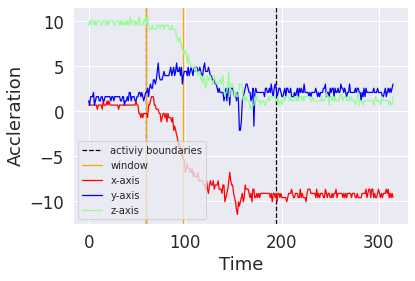

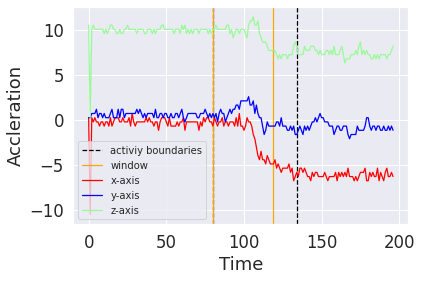

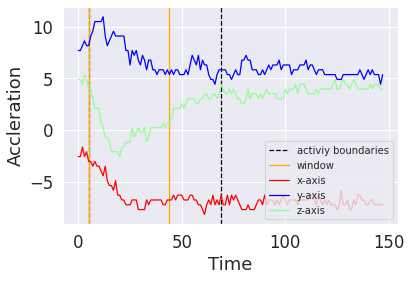

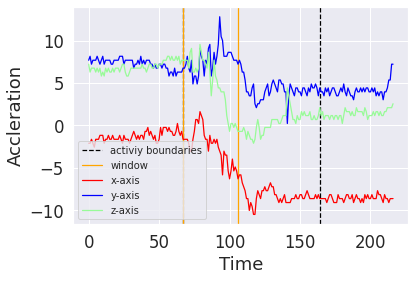

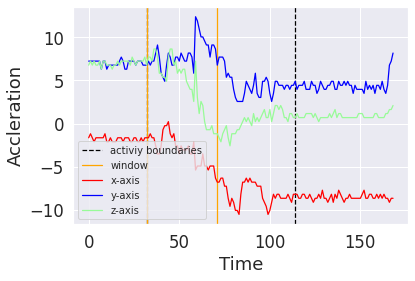

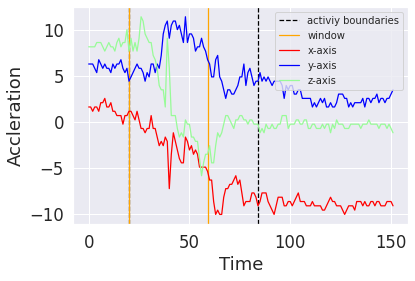

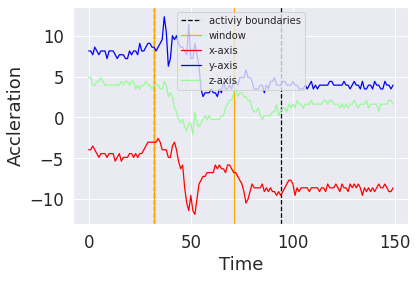

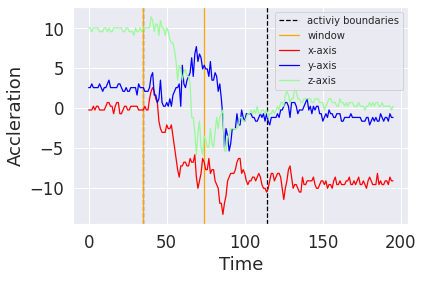

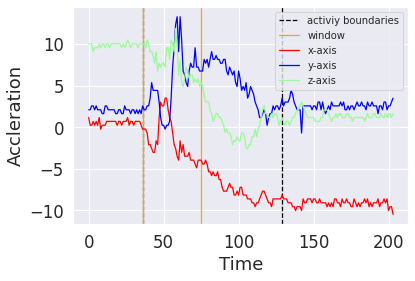

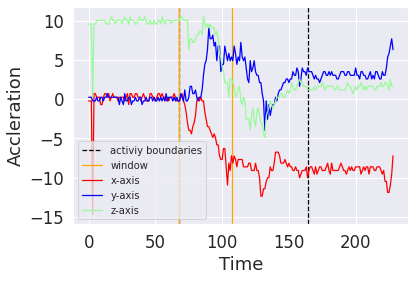

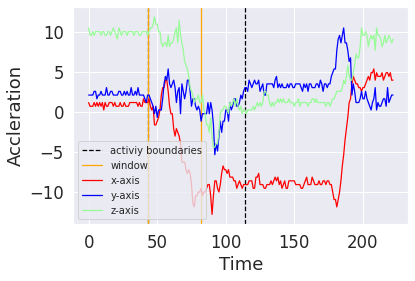

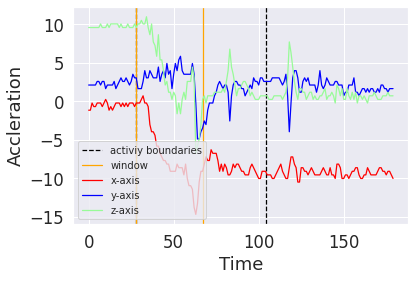

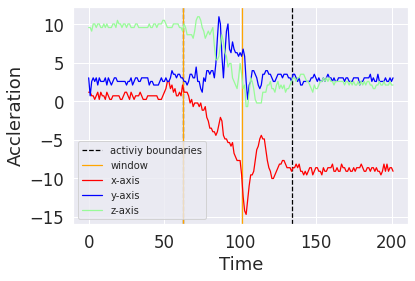

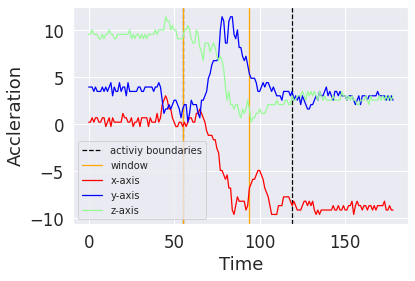

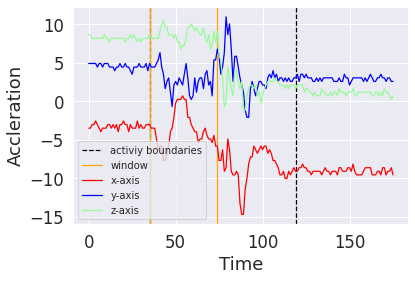

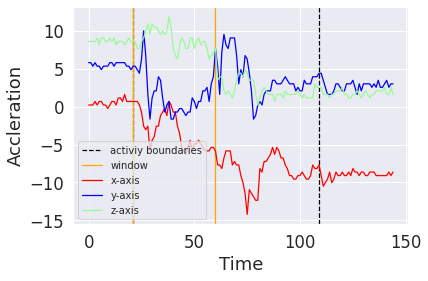

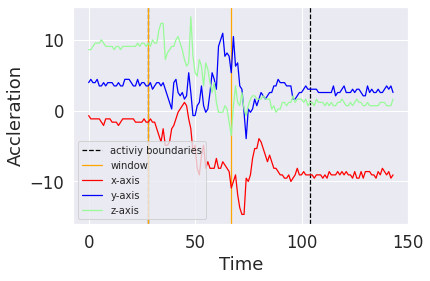

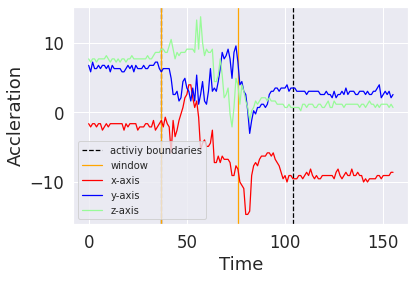

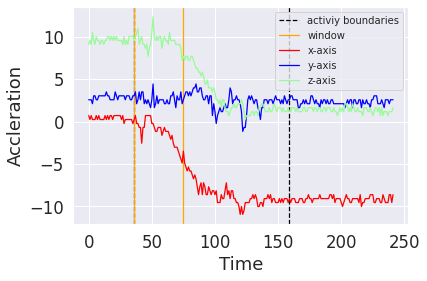

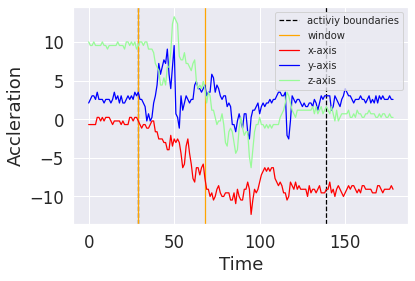

In [36]:
for j in range(20):
    sample = DATA[standup_chair][j]
    lift_windows = initial_find_lift(sample, filtering_params.initial_filtering.rows, filtering_params.initial_filtering.window_size, filtering_params.initial_filtering.stride, filtering_params.initial_filtering.divisor)
    if len(lift_windows) > 0:
        start_time, end_time = get_start_time(lift_windows, rows, filtering_params.precise_filtering.window_size, filtering_params.precise_filtering.stride, filtering_params.precise_filtering.threshold)
        center_window = get_window_from_timestamp(
            sample, start_time + OFFSET, WINDOW_SIZE)
        
        plt.axvline(x=start_time, linestyle='dashed', color = 'black', label = "activiy boundaries")
        plt.axvline(x=end_time, linestyle='dashed', color = 'black')
        plt.axvline(x=center_window[0][-1][0], color = 'orange', label = "window")
        plt.axvline(x=center_window[0][-1][-1], color = 'orange')
        graph_numpy(sample)
       

In [37]:
windows_from_timestamp = preprocess_data(DATA[standup_chair], rows, filtering_params, get_window_from_timestamp, WINDOW_SIZE, OFFSET)
windows_from_timestamp.shape # SHAPE = (num of windows, num of dimension, num of samples)

(102, 4, 40)

#**Plotting**
Below are helpful functions that set up t-SNE, PCA, and ICA plots. These plots can be very useful because they can plot non-2D data on a 2D graph for easy visualization. These visualization can help us see clusterings in our data and ultimately can tell us realtivley how easy 2 or more sets of data will be to differentiate. The more distinct the clustering, the easier these may be to differentiate when using a classification model. We need to preprocess the data before plotting. We need to create 2 numpy arrays of the data we want to compare, and then call the ```get_np_X_Y``` function that will return: 
```
X -- numpy array : [data_type_1 , data_type_2]
Y -- numpy array : [1,1,1,...,1, 0,0,0,...,0]
```

In this example, we will compare STANDUP_CHAIR data and WALK data. We will compare the ```windows_from_timestamp``` and ```center_windows``` from STANDUP_CHAIR with windows of the same size from the WALK dataset.

In [38]:
WINDOW_SIZE = 60

In [39]:
STANDUP_CHAIR_windows =  preprocess_data(DATA["STANDUP_CHAIR"], rows, filtering_params, get_window_from_timestamp, WINDOW_SIZE, OFFSET)
STANDUP_CHAIR_center_windows =  preprocess_data(DATA["STANDUP_CHAIR"], rows, filtering_params, get_window_from_timestamp, WINDOW_SIZE, OFFSET)
WALK_windows = preprocess_data(DATA["WALK"], rows, filtering_params, same_window_size, WINDOW_SIZE, OFFSET)

In [40]:
num_samples = 100

In [41]:
start_time_windowsX, start_time_windowsY = get_np_X_Y(STANDUP_CHAIR_windows[:, :3], WALK_windows[:, :3], num_samples) 
# only want the first 3 dimensions of the sensor features 
print(start_time_windowsY.shape)
print(start_time_windowsX.shape)

(200,)
(200, 3, 60)


In [42]:
center_windowsX, center_windowsY = get_np_X_Y(STANDUP_CHAIR_center_windows[:, :3], WALK_windows[:, :3], num_samples) 
print(center_windowsY.shape)
print(center_windowsX.shape)

(200,)
(200, 3, 60)


In order to send ```compareX``` through the sklearn TSNE function, the array needs to be reshaped to only 2 dimension: 

In [43]:
sample, x, y = start_time_windowsX.shape
start_time_windowsX = start_time_windowsX.reshape((sample, x*y))
print(start_time_windowsX.shape)

(200, 180)


In [44]:
sample, x, y = center_windowsX.shape
center_windowsX = center_windowsX.reshape((sample, x*y))
print(center_windowsX.shape)

(200, 180)


In [45]:
ALPHA = 0.6

Here, will plot Walking vs Standup_chair (windows from start time) and Walking vs Standup_chair (windows centered at start time ) on each type of plot. We can then look at the plots to see which type of window makes the Stanup_chair look the most different from the walking data. 

##**t-SNE**
* t-SNE plotting function takes in :
```
 type_1 -- numpy array
 type_2 -- numpy array
  alpha -- int ( transparency level of the dots on the plot )
 ```

This funciton will plot the 2 different sets of data passed into it. With the plotting function, the ```type_1``` is considered ```positive``` and ```type_2``` is considered ```negative```

In [46]:
n_components = 3 # Number of features 

###**Windows from Start** 

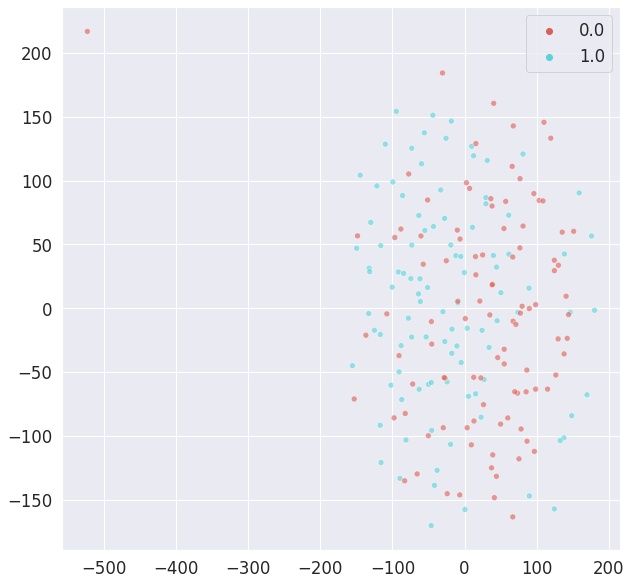

In [47]:
scatter_TSNE(start_time_windowsX, start_time_windowsY, n_components, ALPHA)

###**Windows Centered at Start**

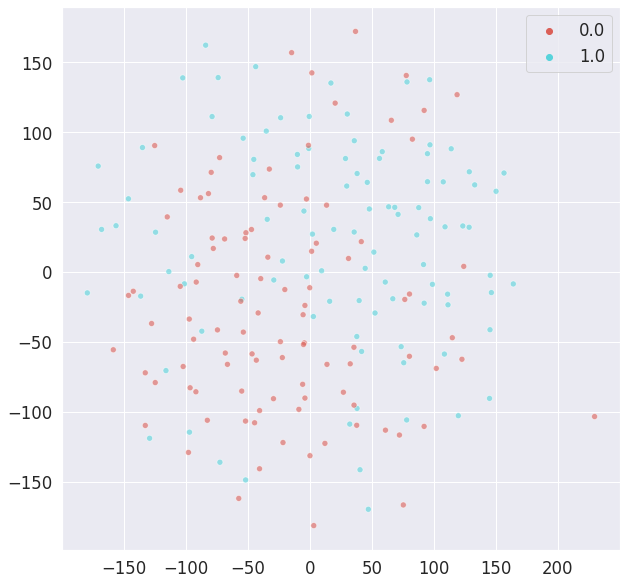

In [48]:
scatter_TSNE(center_windowsX, center_windowsY, n_components, ALPHA)

##**PCA**

###**Windows from Start** 

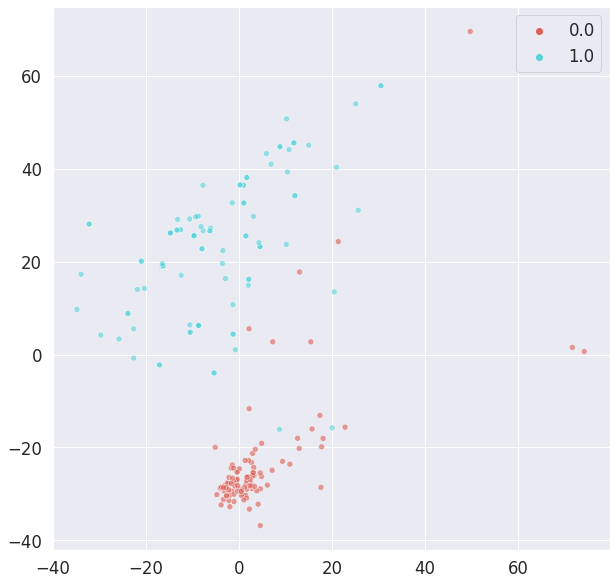

In [49]:
scatter_PCA(start_time_windowsX, start_time_windowsY, n_components, ALPHA)

###**Windows Centered at Start**

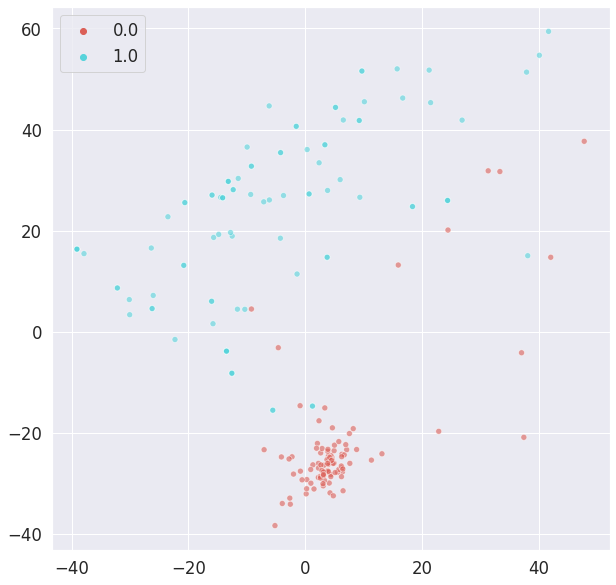

In [50]:
scatter_PCA(center_windowsX, center_windowsY, n_components, ALPHA)

##**ICA**

###**Windows from Start** 

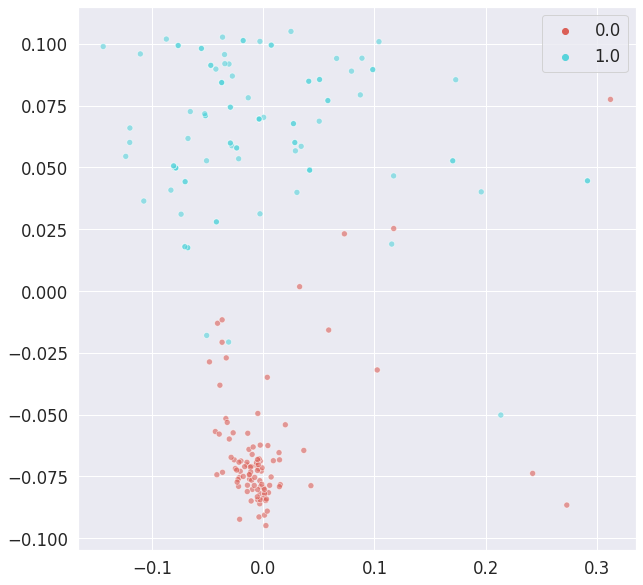

In [51]:
scatter_ICA(start_time_windowsX, start_time_windowsY, n_components, ALPHA)

###**Windows Centered at Start**

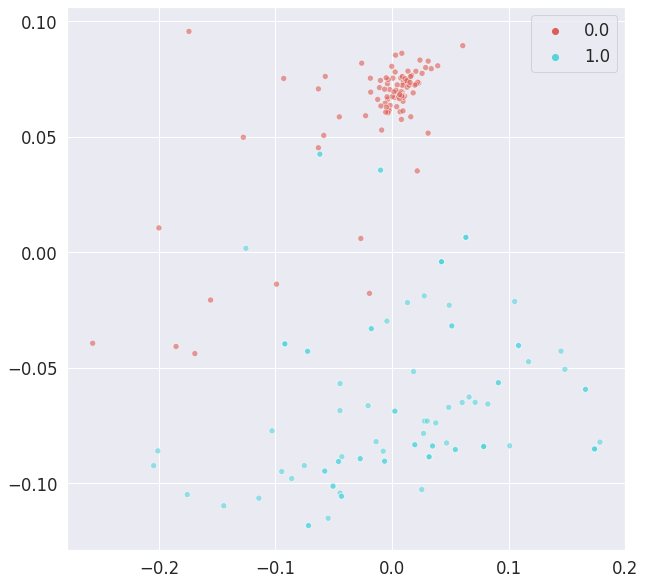

In [52]:
scatter_ICA(center_windowsX, center_windowsY, n_components, ALPHA)

From the plots, we can tell that the Standu_chair with ```windows centered at Start``` generally have a better and more distinct clustering. This tells us that these types of windows might have a better accuracy when used in a classification model. Of course, this is not a hard and fast rule, these plots are still useful to give us more intuition about the data we are working with. 

#**ML Experiments: Classification**
Below, we will set up a simply classification model that will predict if a window contains the action of standing up from a chair or if the window contains the action of walking. 

##**Centered Windows**##

* create a train, test, and validation dictionaries each with a ```"positives"``` and ```"negatives"``` key 
* Numpy arrays of the randomized windows are stored at the keys

Ex:
```
train= { "positives" : [np_array_of_windows], 
         "negatives" : [np_array_of_windows]}
```

In [53]:
MAX_SAMPLES = 100

percent_train = 0.6
percent_test = 0.2
percent_validation = 0.2

When creating the train, test, and validation dictionaries we do not want to include the timeseries data. So, we just use ```data[:, :3]```

In [54]:
train, test, validation = create_train_test_validation(STANDUP_CHAIR_center_windows[:, :3], WALK_windows[:, :3], percent_train, percent_test, percent_validation)

The ```create_dataset``` method returns a ```tf.data.Datatset```

In [58]:
train_dataset = create_dataset(train["positives"], train["negatives"], MAX_SAMPLES)
train_dataset

<TensorSliceDataset shapes: ((3, 60), ()), types: (tf.float64, tf.float64)>

In [59]:
validation_dataset = create_dataset(validation["positives"], validation["negatives"], MAX_SAMPLES)
validation_dataset

<TensorSliceDataset shapes: ((3, 60), ()), types: (tf.float64, tf.float64)>

In [60]:
test_examples, test_labels = get_np_X_Y(test["positives"], test["negatives"], MAX_SAMPLES)
print(test_examples.shape)

(40, 3, 60)


###Batch and Shuffle

In [61]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset_SHUFFLED = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset_SHUFFLED = validation_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

###Build Model

In [62]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(3, 60)),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(1)
])

In [63]:
model.compile(optimizer='adagrad',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [64]:
model.fit(train_dataset_SHUFFLED, epochs = 10, validation_data=validation_dataset_SHUFFLED)

Epoch 1/10
3/3 [==============================] - 0s 46ms/step - loss: 1.6874 - accuracy: 0.4783 - val_loss: 0.6327 - val_accuracy: 0.8182
Epoch 2/10
3/3 [==============================] - 0s 6ms/step - loss: 1.3078 - accuracy: 0.5714 - val_loss: 0.3432 - val_accuracy: 0.9339
Epoch 3/10
3/3 [==============================] - 0s 5ms/step - loss: 0.7137 - accuracy: 0.7081 - val_loss: 0.2746 - val_accuracy: 0.9339
Epoch 4/10
3/3 [==============================] - 0s 6ms/step - loss: 0.6485 - accuracy: 0.7516 - val_loss: 0.2582 - val_accuracy: 0.9504
Epoch 5/10
3/3 [==============================] - 0s 5ms/step - loss: 0.5910 - accuracy: 0.7888 - val_loss: 0.2218 - val_accuracy: 0.9504
Epoch 6/10
3/3 [==============================] - 0s 5ms/step - loss: 0.5597 - accuracy: 0.7764 - val_loss: 0.2011 - val_accuracy: 0.9504
Epoch 7/10
3/3 [==============================] - 0s 6ms/step - loss: 0.5602 - accuracy: 0.7888 - val_loss: 0.1808 - val_accuracy: 0.9421
Epoch 8/10
3/3 [=================

###Test Model

In [65]:
test_loss, test_acc = model.evaluate(test_examples, test_labels, verbose=1) 
print('Test accuracy:', test_acc, "\n")

2/2 [==============================] - 0s 3ms/step - loss: 0.0837 - accuracy: 0.9750
Test accuracy: 0.9750000238418579 



##**Windows from Start Time**##

Now we will run the same ML experiment using the windows from the start time of the activity. We will use the same model architecture for consistancy in the experiment. We can compare the accuracy of both of these experiments to determine which window type is best for deciding whether the activity is taking place in a given window or not. 

We will set up the second experiment exactly the same at the first by first creating the train, test, and validation sets. 

In [66]:
train_2, test_2, validation_2 = create_train_test_validation(STANDUP_CHAIR_windows[:, :3], WALK_windows[:, :3], percent_train, percent_test, percent_validation)

In [67]:
train_dataset_2 = create_dataset(train_2["positives"], train_2["negatives"], MAX_SAMPLES)
train_dataset_2

<TensorSliceDataset shapes: ((3, 60), ()), types: (tf.float64, tf.float64)>

In [68]:
validation_dataset_2 = create_dataset(validation_2["positives"], validation_2["negatives"], MAX_SAMPLES)
validation_dataset_2

<TensorSliceDataset shapes: ((3, 60), ()), types: (tf.float64, tf.float64)>

In [69]:
test_examples_2, test_labels_2 = get_np_X_Y(test_2["positives"], test_2["negatives"], MAX_SAMPLES)
print(test_examples_2.shape)

(40, 3, 60)


In [70]:
test_examples_2, test_labels_2 = get_np_X_Y(test_2["positives"], test_2["negatives"], MAX_SAMPLES)
print(test_examples_2.shape)

(40, 3, 60)


###Batch and Shuffle

In [71]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100

train_dataset_SHUFFLED_2 = train_dataset_2.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_dataset_SHUFFLED_2 = validation_dataset_2.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

###Build Model

In [72]:
model_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(3, 60)),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(40, activation='relu'),
    keras.layers.Dense(1)
])

In [73]:
model_2.compile(optimizer='adagrad',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics=['accuracy'])

In [74]:
model_2.fit(train_dataset_SHUFFLED_2, epochs = 10, validation_data=validation_dataset_SHUFFLED_2)

Epoch 1/10
3/3 [==============================] - 0s 38ms/step - loss: 1.9713 - accuracy: 0.5714 - val_loss: 0.5580 - val_accuracy: 0.8430
Epoch 2/10
3/3 [==============================] - 0s 6ms/step - loss: 1.5433 - accuracy: 0.6025 - val_loss: 0.3845 - val_accuracy: 0.8595
Epoch 3/10
3/3 [==============================] - 0s 7ms/step - loss: 1.0603 - accuracy: 0.6770 - val_loss: 0.3520 - val_accuracy: 0.8926
Epoch 4/10
3/3 [==============================] - 0s 5ms/step - loss: 0.8778 - accuracy: 0.7267 - val_loss: 0.3366 - val_accuracy: 0.9091
Epoch 5/10
3/3 [==============================] - 0s 5ms/step - loss: 0.6759 - accuracy: 0.7702 - val_loss: 0.2872 - val_accuracy: 0.9174
Epoch 6/10
3/3 [==============================] - 0s 6ms/step - loss: 0.6993 - accuracy: 0.7888 - val_loss: 0.2693 - val_accuracy: 0.9256
Epoch 7/10
3/3 [==============================] - 0s 5ms/step - loss: 0.6368 - accuracy: 0.7950 - val_loss: 0.2686 - val_accuracy: 0.9504
Epoch 8/10
3/3 [=================

###Test Model

In [75]:
test_loss_2, test_acc_2 = model_2.evaluate(test_examples_2, test_labels_2, verbose=1) 
print('Test accuracy:', test_acc_2, "\n")

2/2 [==============================] - 0s 3ms/step - loss: 0.0460 - accuracy: 1.0000
Test accuracy: 1.0 



##**Analysis**

The exact accuracy rates can vary every time we re-compile the model and run it again, but we should see that the **Centered Windows** is gerneally outperforming the **Windows at Start Time**. From this we can conclude that the **Centered windows** are better for determining if a lift is happening in a given window that the **Windows at Start Time**. For further research, it may be a good idea to try and optimize a model individually for both types of windows to see which type of window can reach the highest accuracy rates possible, but for the sake of brevity in this experiment we will not run the numerous other experiments fine-tuning the hyper-parameters of the models. 



#**Data Augmentation**

The data augmentation funtions take a numpy array with shape = ```(length_of_samples, dimensions)``` so in this case we need to tranpose the data if we are calling any ```DA_(augment)``` function indepently of the ```preprocess_with_augmentation``` function which handles the transposition. When using these augmentation functions, we normally just specify the ```sigma``` which is used to calculate how big of a change to apply to the trace, but everytime we run the augmentation functions they randomize the augment where ```sigma``` is the upper bound. Thus the augmentations will be different each time even if run on the same trace. 

Data augmentation can be very useful to generate more usable and trainable data from the original set of data. By augmenting the data we already have, we can "reuse" the original data by making it different enough to be seen as "new". 

One use case of this is when we do not have a large dataset and want to increase the size of our dataset by augmenting samples we already have and adding these to our data. This may help us train a model mor accureatly because it is seeing more data and different data. 

In [76]:
SAMPLE = np.array(DATA["STANDUP_CHAIR"][0][:3])

##**Jittering**

**Hyper Parameters = SIGMA**

In [77]:
SIGMA = 0.5

NO AUGMENT


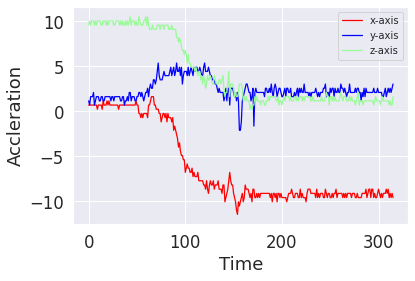

In [78]:
print("NO AUGMENT")
graph_numpy(SAMPLE)

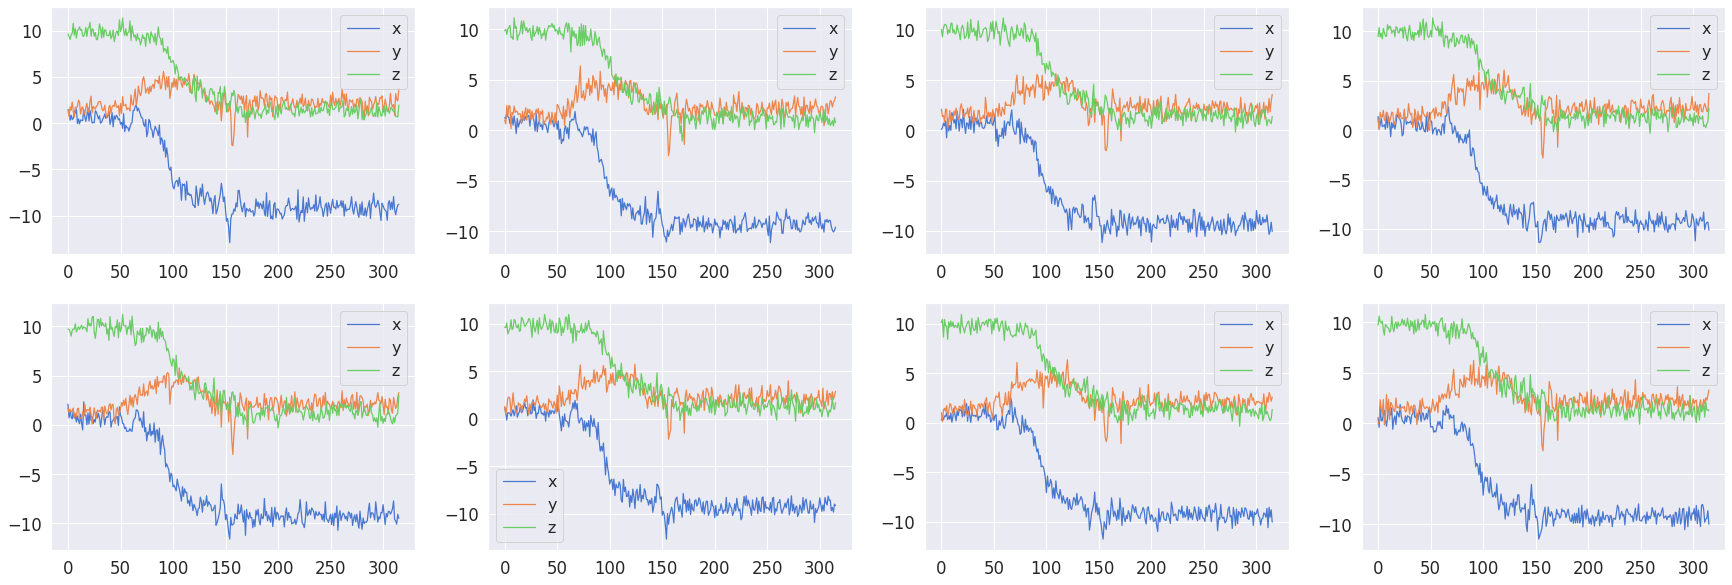

In [79]:
fig = plt.figure(figsize=(30,10))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    rotated = (DA_Jitter(SAMPLE.transpose(), SIGMA))
    ax.plot(rotated[:,0], label ='x')
    ax.plot(rotated[:,1], label ='y')
    ax.plot(rotated[:,2], label ='z')
    ax.legend(loc='best', prop={"size":16})

* Increasing **SIGMA** will increase the amount of jittering in the trace




Use ```preprocess_with_augemtation``` to get a list of all the traces with the desired augments:

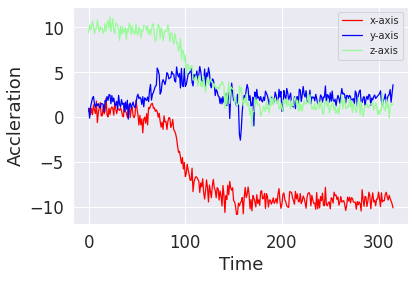

In [80]:
standup_chair_JITTERED = preprocess_add_augmentation(DATA["STANDUP_CHAIR"], DA_Jitter, SIGMA)

graph_numpy(standup_chair_JITTERED[0])

##**Time Warping**


Time warping the sample will split up the trace into equally sized windows and then changes the frequency of the samples within these windows. This gives the affect of "warping" different parts of the trace at different rates. 

In [81]:
SIGMA = 0.5

NO AUGMENT


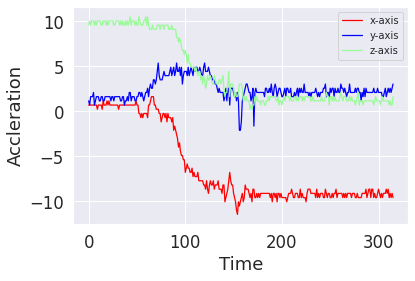

In [82]:
print("NO AUGMENT")
graph_numpy(SAMPLE)

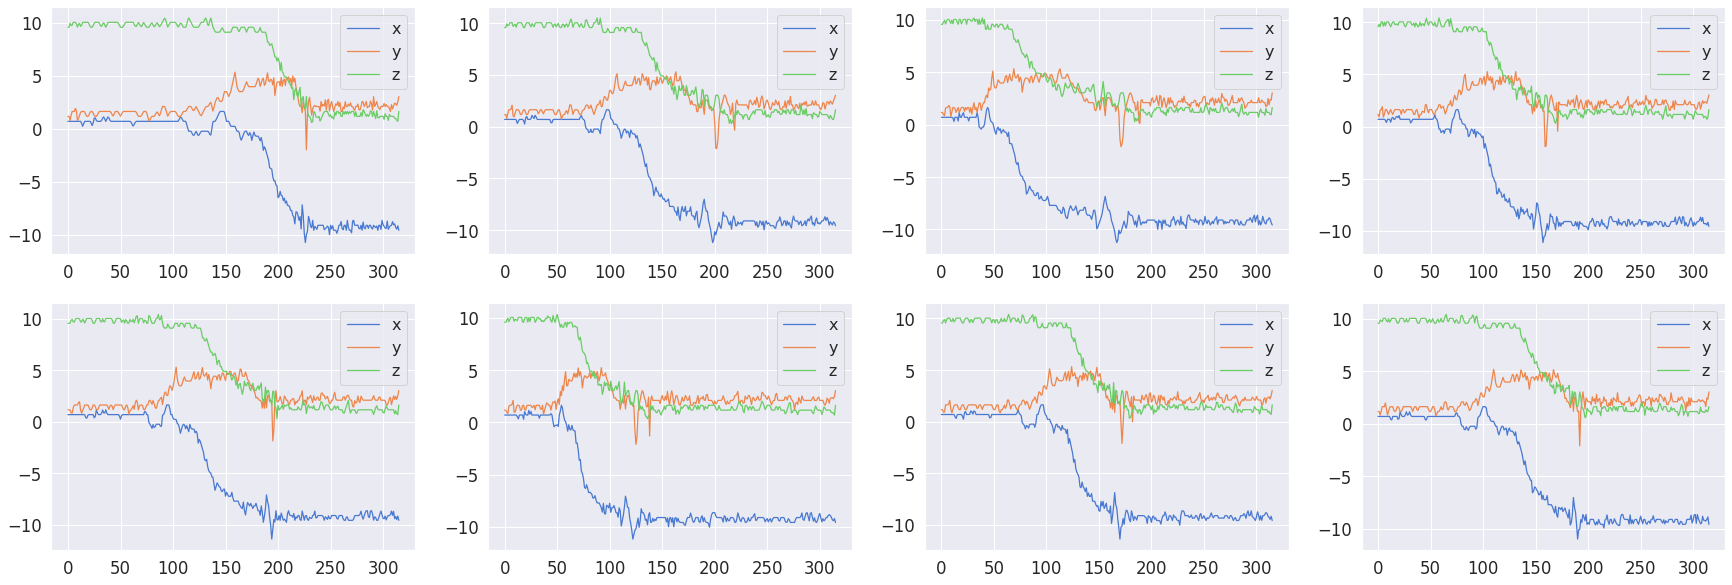

In [83]:
fig = plt.figure(figsize=(30,10))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    rotated = (DA_TimeWarp(SAMPLE.transpose(), SIGMA))
    ax.plot(rotated[:,0], label ='x')
    ax.plot(rotated[:,1], label ='y')
    ax.plot(rotated[:,2], label ='z')
    ax.legend(loc='best', prop={"size":16})

Again we can use ```preprocess_with_augmentation``` function to apply these augmentations to all traces in a list. 

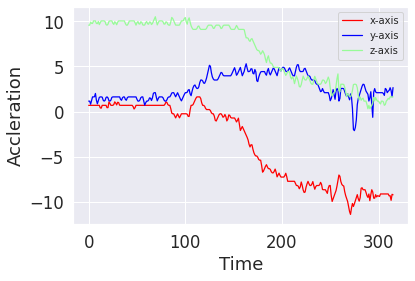

In [84]:
standup_chair_TIMEWARP = preprocess_add_augmentation(DATA["STANDUP_CHAIR"], DA_TimeWarp, SIGMA)

graph_numpy(standup_chair_TIMEWARP[0])

##**Rotation**


###**Random Rotation**

The rotation function ```DA_Rotation``` does not have a ```sigma``` as a parameter and gerenates the axis of rotation and also the angle of rotation. 

NO AUGMENT


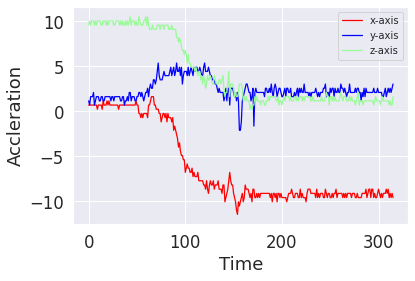

In [85]:
print("NO AUGMENT")
graph_numpy(SAMPLE)

Rotation


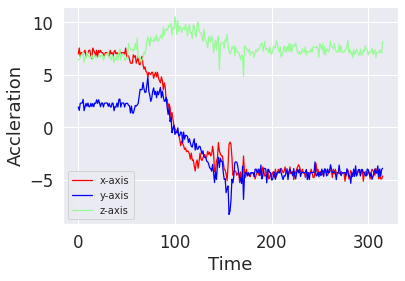

In [86]:
rotated_sample = DA_Rotation(SAMPLE.transpose()).transpose()
print("Rotation")
graph_numpy(rotated_sample)

To make this clearer, below we run the ```DA_Rotation``` function on the same trace to show how the randomization of the axis and angle of rotation affect the trace:

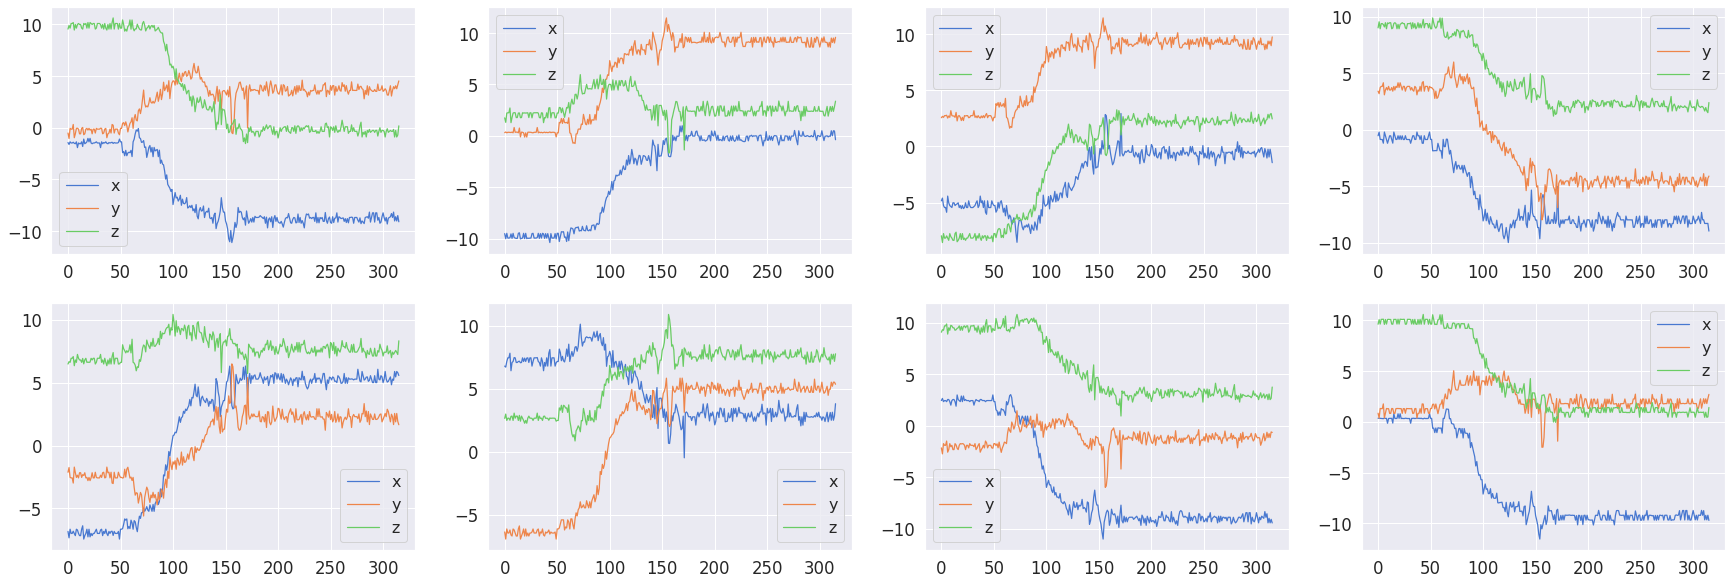

In [87]:
fig = plt.figure(figsize=(30,10))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    rotated = (DA_Rotation(SAMPLE.transpose()))
    ax.plot(rotated[:,0], label ='x')
    ax.plot(rotated[:,1], label ='y')
    ax.plot(rotated[:,2], label ='z')
    ax.legend(loc='best', prop={"size":16})

###**Specific Rotation**

We can also use the function ```DA_Rotation_specific``` to specify a certain axis and angles of rotation. 

*   ```DA_Rotation_specific(X, angle_low, angle_high, axis)```
    * ```angle_low, angle_high : radians```
    * ```axis : numpy array, for each axis assign a value to determine how it will be rotated, SHAPE = (3). ```
        * Ex: if our data is structured as ```[x, y, z]``` if ```axis = [1.0, 0, 0]``` then the rotations will only be around the ```x``` axis. 





In [88]:
AXIS = np.array([1.0, 0, 0]) # rotate around the x axis
ANGLE_LOW = -np.pi/4; # -45 degrees
ANGLE_HIGH = np.pi/4; # 45 degrees

NO AUGMENT


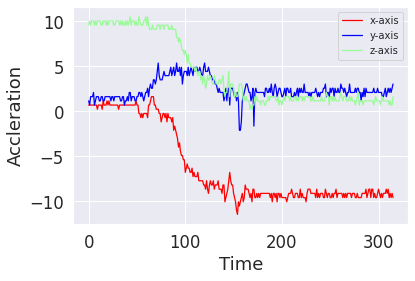

In [89]:
print("NO AUGMENT")
graph_numpy(SAMPLE)

Rotation


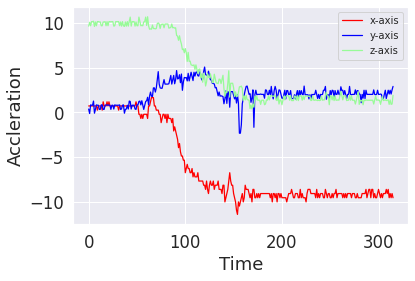

In [90]:
rotated_sample = DA_Rotation_specific(SAMPLE.transpose(), ANGLE_LOW, ANGLE_HIGH, AXIS).transpose()
print("Rotation")
graph_numpy(rotated_sample)

*   In this examples, we rotate around the ```x axis``` between ```-pi/4``` and ```pi/4``` (-45 to 45 degrees) 



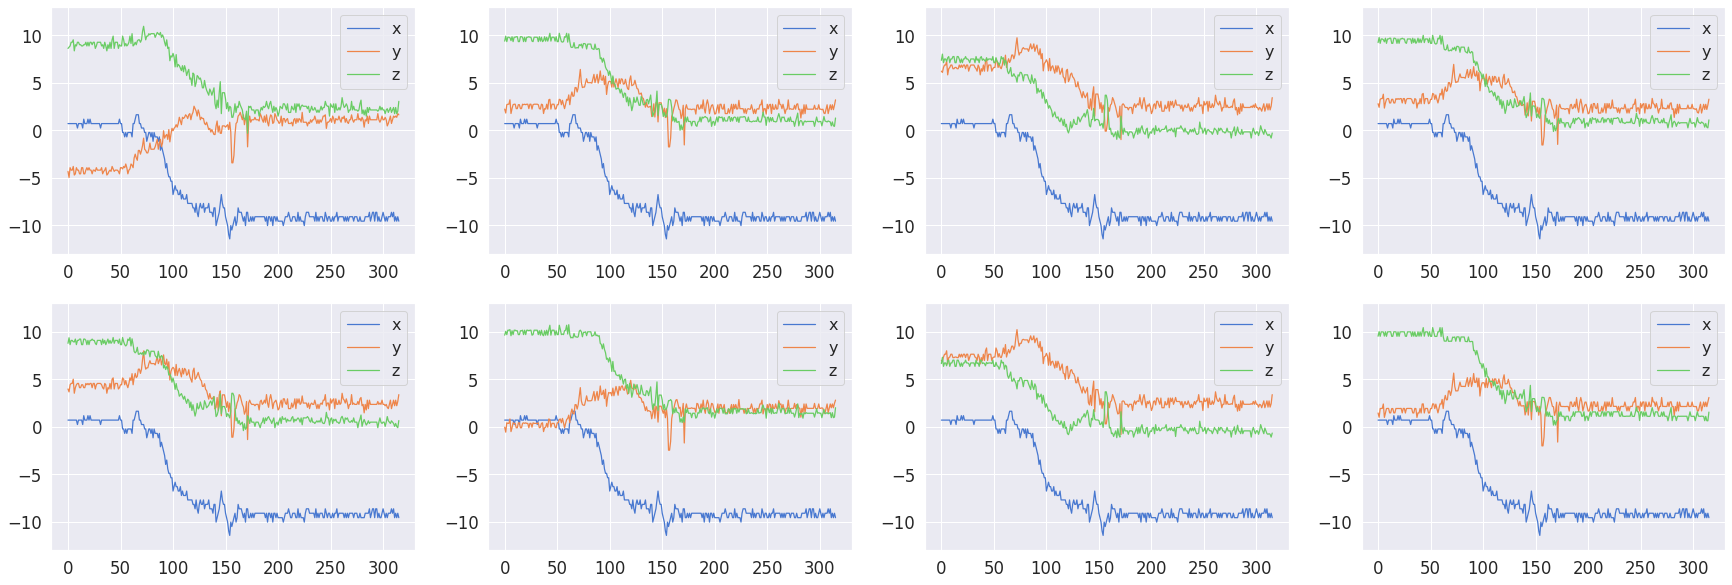

In [91]:
fig = plt.figure(figsize=(30,10))

for i in range(8):
    ax = fig.add_subplot(2,4,i+1)
    rotated = (DA_Rotation_specific(SAMPLE.transpose(), ANGLE_LOW, ANGLE_HIGH, AXIS))
    ax.set_ylim([-13, 13])
    ax.plot(rotated[:,0], label ='x')
    ax.plot(rotated[:,1], label ='y')
    ax.plot(rotated[:,2], label ='z')
    ax.legend(loc='best', prop={"size":16})